# **Save this file as studentid1_studentid2_lab2.ipynb**, please check this suffix when you upload your lab, especially when you have multiple copy's in the same folder!
(Your student-id is the number shown on your student card.)

E.g. if you work with 3 people, the notebook should be named:
12301230_3434343_1238938934_lab2.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "Dimitris Loupas"
EMAIL = "d.loupas@students.uu.nl"


# Lab 2: Classification

### Machine Learning 1, November 2018

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Use the provided test cells to check if your answers are correct
* **Make sure your output and plots are correct before handing in your assignment with Kernel -> Restart & Run All**

* **If possible, all your implementations should be vectorized and rely on loops as little as possible. Therefore for some questions, we give you a maximum number of loops that are necessary for an efficient implementation. This number refers to the loops in this particular function and does not count the ones in functions that are called from the function. You should not go above this number for the maximum number of points.**

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

#import time
#start = time.time()

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

In [4]:
!pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [5]:
from sklearn.datasets import fetch_openml
import os
# Fetch the data
try:
    mnist = fetch_openml("mnist_784", version=1, return_X_y=False, as_frame=False, parser="pandas")
except Exception:
    raise FileNotFoundError('Please download mnist-original.mat from Canvas and put it in %s/mldata' % os.getcwd())
data, target = mnist.data, mnist.target.astype('int')
# Shuffle
indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255.

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

MNIST consists of small 28 by 28 pixel images of written digits (0-9). We split the dataset into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

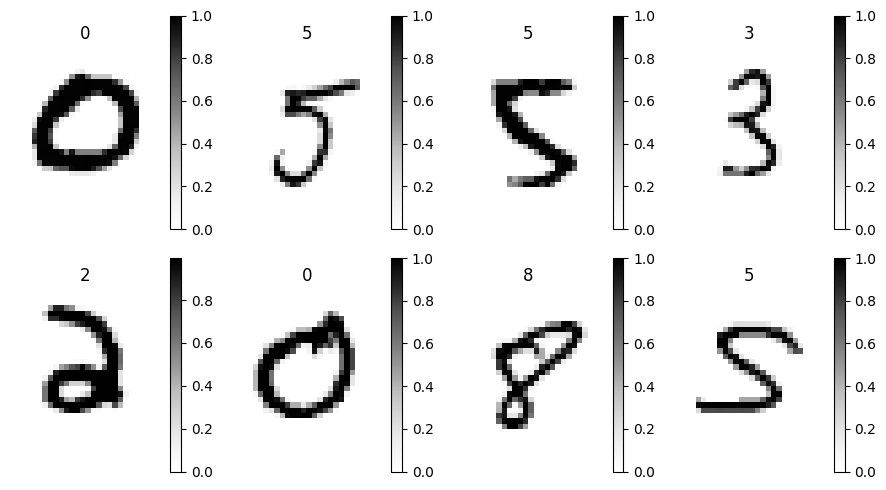

In [6]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class.

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization
### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z}
\frac{\partial Z}{\partial \log q_j}
= 1
-
\frac{\partial \log Z}{\partial Z}
\frac{\partial Z}{\partial \log q_j}
$$

For $j \neq t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z}
\frac{\partial Z}{\partial \log q_j}
=0 - \frac{\partial \log Z}{\partial Z}
\frac{\partial Z}{\partial \log q_j}
$$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.



YOUR ANSWER HERE

$\frac{\partial \log Z}{\partial Z}=\frac{1}{Z}$

using $Z = \sum_i q_i = \sum_i e^{\log q_i}$

$\frac{\partial Z}{\partial \log q_j}= \frac{\partial \sum_i e^{\log q_i}}{\partial \log q_j}=\sum_i e^{\log q_i} \delta_{ij}=e^{\log q_j}$

Hence



For $j = t^{(n)}$:
\begin{align}
\delta^q_j
&=1-Z^{-1}e^{\log(q_j)}
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
&=-Z^{-1}e^{\log(q_j)}
\end{align}


Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is:

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

YOUR ANSWER HERE

$\frac{\partial \log q_j}{\partial W_{ij}}= \frac{\partial \sum_k W_{kj}x_k+b_j}{\partial W_{ij}}=\sum_k \delta_{ik}x_k=x_i$

Hence

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} = \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q x_i
$

$
\nabla_{w_j}\mathcal{L}^{(n)} = \mathbf{\delta}_j^q\mathbf{x}^{(n)}
$

### 1.1.2 Implement gradient computations (15 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [7]:
# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b
def logreg_gradient(x, t, w, b):
  log_q= w.T@x.T +b.reshape(len(b),1)
  #print(log_q.shape,w.T.shape, x.T.shape, b.shape)
  a = np.max(log_q)

  log_Z = a + np.log(np.sum(np.exp(log_q-a)))

  log_p = log_q - log_Z

  delta = np.zeros_like(log_q)
  delta[t]=1
  delta = delta-(1/np.exp(log_Z))*np.exp(log_q)
  #print(log_p.shape)
  dL_db= delta
  dL_dW= (delta@x).T
  logpt =log_p[t].squeeze()
  return logpt, dL_dW, dL_db.squeeze()

In [8]:
np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

# test gradients, train on 1 sample
logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)

print("Test gradient on one point")
print("Log Likelihood:\t", logpt)
print("\nGrad_W_ij\t",grad_w.shape,"matrix")
print("Grad_W_ij[0,152:158]=\t", grad_w[152:158,0])
print("\nGrad_B_i shape\t",grad_b.shape,"vector")
print("Grad_B_i=\t", grad_b.T)
print("i in {0,...,9}; j in M")

assert logpt.shape == (), logpt.shape
assert grad_w.shape == (784, 10), grad_w.shape
assert grad_b.shape == (10,), grad_b.shape




Test gradient on one point
Log Likelihood:	 -2.296585968775302

Grad_W_ij	 (784, 10) matrix
Grad_W_ij[0,152:158]=	 [0.81827609 0.88881713 0.61018003 0.29979944 0.29979944 0.29979944]

Grad_B_i shape	 (10,) vector
Grad_B_i=	 [ 0.89939828 -0.09837106 -0.1015878  -0.10029629 -0.0983651  -0.10186094
 -0.10139518 -0.09875533 -0.09922724 -0.09953934]
i in {0,...,9}; j in M


In [9]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))
print(x_train[0:1,:].shape)
def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



(1, 784)
Finite difference error grad_w: 4.887373553270446e-07
Finite difference error grad_b: 1.9820927172954207e-08



### 1.1.3 Stochastic gradient descent (15 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1e-6`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [10]:
def sgd_iter(x_train, t_train, w, b):
    N=x_train.shape[0]
    eta = 1e-6
    logp_train = 0

    # Shuffle
    indices = np.arange(N)
    np.random.shuffle(indices)
    x, t = x_train[indices], t_train[indices]

    for i in range(N):
      x_n, t_n=x[i], t[i]
      #print(x_n.shape, t_n.shape)
      logpt, dL_dW, dL_db=logreg_gradient(x_n.reshape(1,len(x_n)), t_n, w, b) #reshape from (784, ) to (1, 784)
      w = w + eta*dL_dW
      b = b + eta*dL_db
      logp_train = logp_train+logpt
    logp_train=logp_train/N
    return logp_train, w, b

In [11]:
# Sanity check:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10,)

logp_train, W, b = sgd_iter(x_train[:5], t_train[:5], w, b)




## 1.2. Train

### 1.2.1 Train (12 points)
Perform SGD on the training set. Plot (in one graph) the conditional log-probability of the training set and validation set after each iteration. (6 points)

Instead of running SGD for a fixed number of steps, run it until convergence. Think of a reasonable criterion for determining convergence. As a reference: choose a criterion such that the algorithm terminates in less than 15 iterations over the training set. (2 points)

Make sure your implementation (in particular, the output of the conditional log-probability of the training set and validation set) is independent of the size of the dataset. (2 points)

In [12]:
def training(x_train, t_train, x_valid, t_valid, w, b):
    epsilon = 2.
    diff = 100.
    epoch = []
    log_train = []
    log_val = []
    i=0
    w_old = w.copy()
    b_old = b.copy()
    while diff>epsilon:
      logp_train ,w_new, b_new = sgd_iter(x_train, t_train, w_old, b_old)
      logp_val, _, _ = sgd_iter(x_valid, t_valid, w_old, b_old)
      diff = np.sum(np.abs(w_old-w_new))#/np.sum(np.abs(w_old))
      print("Epoch ",i," diff: ", diff)
      epoch.append(i)
      log_train.append(logp_train)
      log_val.append(logp_val)
      i=i+1
      w_old = w_new.copy()
      b_old = b_new.copy()

    #Plot
    plt.plot(epoch,log_train, label='trainning')
    plt.plot(epoch,log_val, label='validation')
    plt.xlabel('epoch')
    plt.ylabel('log p')
    plt.title("log probabilites over itterations")

    plt.legend()

    plt.show()

    return w_new, b_new

Epoch  0  diff:  2.565944791462884
Epoch  1  diff:  2.507811105134464
Epoch  2  diff:  2.4540017179911042
Epoch  3  diff:  2.4036825200348666
Epoch  4  diff:  2.3558415654193685
Epoch  5  diff:  2.3099750078270826
Epoch  6  diff:  2.266145655895833
Epoch  7  diff:  2.2236832840197827
Epoch  8  diff:  2.182089882896723
Epoch  9  diff:  2.141810713520778
Epoch  10  diff:  2.101831119902886
Epoch  11  diff:  2.0629254553599488
Epoch  12  diff:  2.024754331299979
Epoch  13  diff:  1.987441910292123


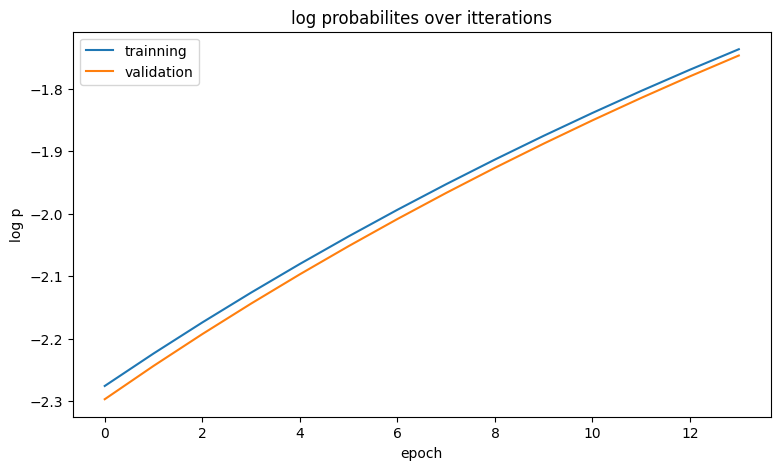

In [13]:
w = np.zeros((28*28, 10))
b = np.zeros(10)
w, b = training(x_train, t_train, x_valid, t_valid, w, b)

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


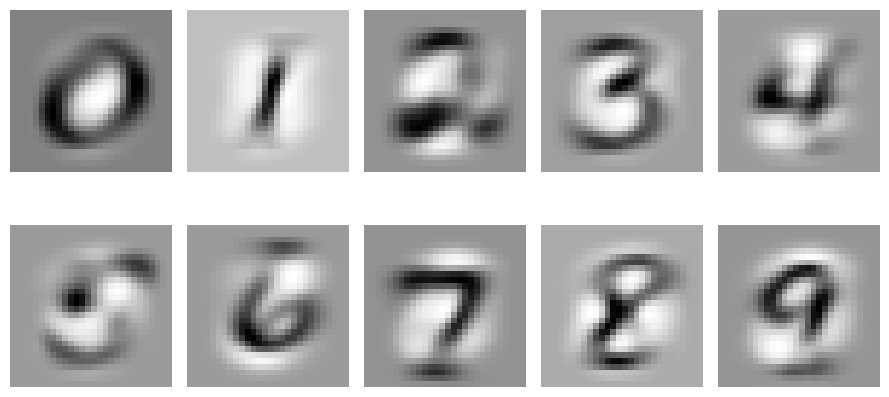

In [14]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))

        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_digits(w.T, num_cols=5)

**Describe in less than 100 words why these weights minimize the loss**

These weights are minimizing the loss as they are greater in similar places as would written digits be. Thus,
they would be learning where handwritten digits would be. Sometimes we can see clearly which digits they try to fit
as in the case of 0 or 3, but as the digit could be written in diffrent maners it would have to fit all that writting space
hence making a bit unclear which digit they try to fit, still this minimizes the loss as the model tries to fill all the possible given writtings based uupon their occurences in the training set.

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.


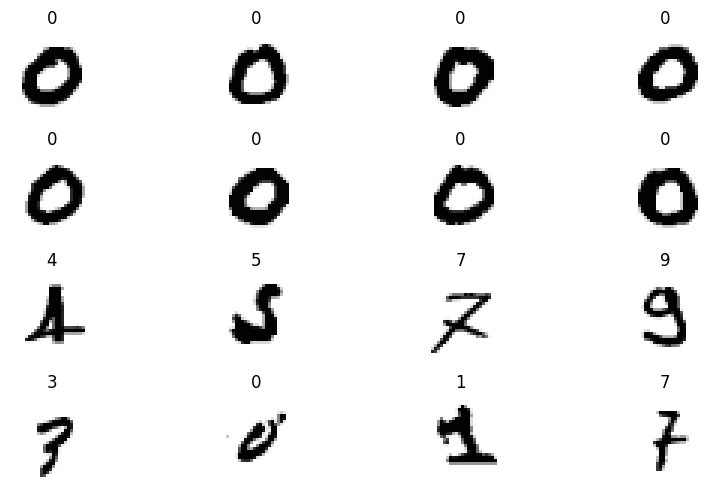

In [15]:
def model_prob(x, w, b):
  #returns log p of the model
  log_q= w.T@x.T +b.reshape(len(b),1)

  a = np.max(log_q)

  log_Z = a + np.log(np.sum(np.exp(log_q-a)))

  log_p = log_q - log_Z

  return log_p

def visualize(x, t, w, b):
  N=x.shape[0]
  digits = np.zeros((16, 784))
  targets = np.zeros((16, ))
  logp=[]

  for id in range(N):
    logp.append((model_prob(x[id].reshape(1,len(x[id])),w,b)[t[id]][0],id))

  i=0
  for k,m in sorted(logp,reverse=True)[:8]:
    digits[i]=x[m].reshape(1, 784)
    targets[i] = t[m]
    i=i+1
  for k,m in sorted(logp)[:8]:
    digits[i]=x[m].reshape(1, 784)
    targets[i] = t[m]
    i=i+1

  plot_digits(digits, num_cols=4, targets=targets)


visualize(x_valid[:],t_valid[:], w, b)


Ask yourself if these results make sense. Explain in no more then two sentences what it means that a digit is hard to classify.

YOUR ANSWER HERE
A digit is hard to classify if it resembeles to another digit, these results make sens since 7 may have common lines to the way we write 1 or 4. We can see that we don't have this problem with 2 as it does not resemble any other digit. Briefly, the more the digits have in common of their way of writting, the darder they are to classify.

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron will have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$).

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$.

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

YOUR ANSWER HERE

$
\mathbf{\delta}_i^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}\frac{\partial \log q_j}{\partial \bh_i} =
\delta_j^q \frac{\partial \sum_k w_{kj}\bh_k +b_j}{\partial \bh_i }=
\delta_j^q \sum_k w_{kj}\delta_{ki}=w_{ij}\delta_j^q
$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_k} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}\frac{\partial \log q_j}{\partial b_k} =
\delta_j^q \frac{\partial \sum_k w_{kj}\bh_k +b_j}{\partial b_k }  =
\delta_j^q \delta_{jk}=\delta_k^q
$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial w_{ml}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}\frac{\partial \log q_j}{\partial w_{ml}} = \delta_j^q \frac{\partial \sum_k w_{kj}\bh_k +b_j}{\partial w_{ml} }= \delta_j^q \sum_k \delta_{km}\delta_{jl}\bh_k=
\delta_j^q \delta_{jl}\bh_m= \delta_l^q \bh_m
$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial V_{ml}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}\frac{\partial \log q_j}{\partial \bh_{l}}\frac{\partial \bh_l}{\partial V_{ml}}=
\delta_j^q w_{lj}\bh_l (1- \bh_l)\frac{\partial \sum_k V_{kl}\bx_k +a_l}{\partial V_{ml} }= \delta_j^q w_{lj}\bh_l (1- \bh_l)x_m=
\delta_l^h\bh_l (1- \bh_l)x_m
$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial a_m} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}\frac{\partial \log q_j}{\partial \bh_{l}}\frac{\partial \bh_l}{\partial a_{m}}=
\delta_j^q w_{lj}\bh_l (1- \bh_l)\frac{\partial \sum_k V_{lk}\bx_k +a_l}{\partial a_{m} }=
\delta_j^q w_{lj}\bh_l (1- \bh_l)\delta_{lm}=
\delta_l^h\bh_l (1- \bh_l)\delta_{lm}=\delta_m^h\bh_m (1- \bh_m)
$

YOUR ANSWER HERE

$
\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j} =
\frac{\partial\log q_j}{\partial \bh_j } - \frac{\partial\log Z}{\partial \bh_j } =
\frac{\partial\bw_j^T \bh + b_j}{\partial \bh_j } - \frac{ \log Z}{\partial Z} \frac{\partial Z}{\partial \bh_j} =
w_{jj} - Z^{-1}\frac{\partial Z}{\partial \bh_j}=
w_{jj} - Z^{-1}\frac{\partial\sum_i e^{\log q_i}}{\partial \log q_j}\frac{\log q_j}{\partial \bh_j}=
w_{jj}(1 - Z^{-1} e^{\log q_j}) =
w_{jj}\mathbf{\delta}_j^q
$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_k} =
\frac{\partial\log q_j}{\partial  b_k } - \frac{\partial\log Z}{\partial  b_k } =
\frac{\partial\bw_j^T \bh + b_j}{\partial b_k } - \frac{\partial\log Z}{\partial Z}\frac{\partial Z}{\partial b_k} =
(j==k) - Z^{-1} \frac{\sum_i e^{log q_i}}{b_k}=
(j==k) - Z^{-1} e^{log q_k} =
\delta^q_k
$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b} = \delta^q
$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial\log q_j}{\partial  W_{ij} } - \frac{\partial\log Z}{\partial  W_{ij} } =
\frac{\partial\bw_j^T \bh + b_j}{\partial W_{ij} } - \frac{\partial\log Z}{\partial Z}\frac{\partial Z}{\partial W_{ij}}=
h_i - Z^{-1}e^{\ln q_j}h_i =
h_i(1 - Z^{-1}e^{\ln q_j}) =
h_i\mathbf{\delta}_j^q
$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial w} = h^T\mathbf{\delta}^q
$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial V_{j}} =
\frac{\partial\bw_j^T \bh + b_j}{\partial V_{j} } - \frac{\partial\log Z}{\partial Z}\frac{\partial Z}{\partial V_{j}}=
w_{jj}h_j(1-h_j)x_j(1 - Z^{-1} e^{log q_j}) =
w_{jj}h_j(1-h_j)x_j\mathbf{\delta}_j^q
$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial V} = w_{j}h(1-h)x\mathbf{\delta}^q
$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial a_j} =
\frac{\partial\bw_j^T \bh + b_j}{\partial a_j } - \frac{\partial\log Z}{\partial Z}\frac{\partial Z}{\partial a_j}=
w_{jj}h_j(1-h_j)(1 - Z^{-1} e^{log q_j}) =
w_{jj}h_j(1-h_j)\mathbf{\delta}_j^q
$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial a} =
w_{j}h(1-h)\mathbf{\delta}^q
$


## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters.

For determining the maximum a posteriori solution we must also determine the parameters for the gaussian prior which would
tell us how likely each class it is. Thus, would to find the optimal mean and variance for this prior. Also we would do these calculations in the logaritmic space for making them simpler. The only diffrence this time would be that we will not derivate only after $\mathcal{L}^{(n)}$ but by $\mathcal{L}^{(n)}$ times the gaussian prior. We would not take account of the evidence as it is not influenced by any of this parameters.

## 2.3. Implement and train a MLP (15 points)

Implement an MLP model with a single hidden layer of **20 neurons**.
Train the model for **10 epochs**.
Test your implementation for learning rates of 1e-2, 1e-3 and 1e-4 and plot (in one graph) the conditional log-probability of the trainingset and validation set.

For the best model plot the weights of the first layer for in epoch 0,4 and 9.


- 10 points: Working MLP that learns with plots
- +5 points: Fast, numerically stable, vectorized implementation

In [16]:
import numpy as np
# Write all helper functions here
def sigmoid(x):
  return 1. / (1. + np.exp(-x))

def forward(x,W,b,V,a):
  #print(V.T.shape,x.shape)
  #print(W.T.shape, b.shape)
  h = sigmoid(V.T@x + a)#+ b.reshape(len(b),1))
  #print("h",h.shape, b.shape)
  log_q = W.T@h + b#+ a.reshape(len(a),1)
  a = np.max(log_q)
  logZ = a + np.log(np.sum(np.exp(log_q - a)))
  log_p = log_q -logZ

  return log_p, log_q, logZ, h



def mlp_grad(x, t, W, b, V, a):

  log_p, log_q, log_Z, h = forward(x,W,b,V,a)

  delta = np.zeros_like(log_q)
  delta[t]=1
  delta = delta-(1/np.exp(log_Z))*np.exp(log_q)
  #print(log_p.shape)
  dLdb= delta

  delta_h = dLdb @ W.T


  dLdV = np.outer(x,delta_h * h*(1 - h))
  dLdW = np.outer(h , delta)
  dLda = delta_h*h*(1-h)
  #print(h.shape, delta_h.shape)

  return log_p[t], dLdW, dLdb, dLdV, dLda


In [17]:
def init_mlperceptron_weights(num_of_features, num_of_class, L):
    W = (np.random.random_sample((L, num_of_class)) - 0.5) * 0.001
    b = (np.random.random_sample(num_of_class) - 0.5) * 0.001
    V = (np.random.random_sample((num_of_features, L)) - 0.5) * 0.001
    a = (np.random.random_sample(L) - 0.5) * 0.001
    return W, b, V, a

In [18]:
# Test
np.random.seed(0)
L = 20
W, b, V, a = init_mlperceptron_weights(784, 10, L)
print(W.shape)
_,grad_W, grad_b, grad_V, grad_a = mlp_grad(x_train[0], t_train[0], W, b, V, a)
print(grad_W.shape, grad_b.shape, grad_V.shape, grad_a.shape)

(20, 10)
(20, 10) (10,) (784, 20) (20,)


===== lr = 0.01=====
Epoch  0  logp:  -0.783763555173798
Epoch  1  logp:  -0.2695241215823297
Epoch  2  logp:  -0.22536635318222928
Epoch  3  logp:  -0.20091330972881039
Epoch  4  logp:  -0.18291007507185003
Epoch  5  logp:  -0.16948037843753616
Epoch  6  logp:  -0.15984614750794884
Epoch  7  logp:  -0.15100598755108932
Epoch  8  logp:  -0.14377001040856957
Epoch  9  logp:  -0.13821951537247262
===== lr = 0.001=====
Epoch  0  logp:  -2.237324460787442
Epoch  1  logp:  -1.359618135956695
Epoch  2  logp:  -0.7350469869162914
Epoch  3  logp:  -0.505445425678519
Epoch  4  logp:  -0.40898974121395504
Epoch  5  logp:  -0.36046960125318606
Epoch  6  logp:  -0.3307627500208117
Epoch  7  logp:  -0.31007985184069153
Epoch  8  logp:  -0.2944075427994055
Epoch  9  logp:  -0.281369993528434
===== lr = 0.0001=====
Epoch  0  logp:  -2.3014142040633283
Epoch  1  logp:  -2.300978993610967
Epoch  2  logp:  -2.300401474679952
Epoch  3  logp:  -2.2990888981798387
Epoch  4  logp:  -2.2958335987143954
Epoch

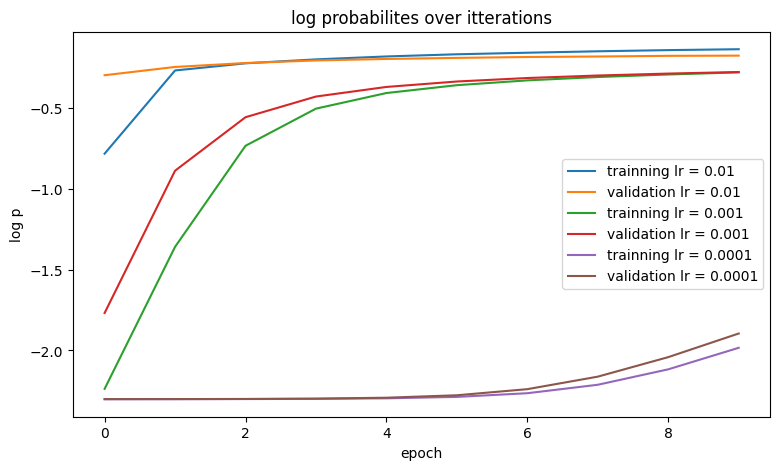

In [19]:
# Write training code here:
# Plot the conditional loglikelihoods for the train and validation dataset after every iteration.
# Plot the weights of the first layer.



def sgd_mlp_iter(x_train, t_train, W, b, V, a, lr):
    N=x_train.shape[0]
    logp_train = 0

    # Shuffle
    indices = np.arange(N)
    np.random.shuffle(indices)
    x, t = x_train[indices], t_train[indices]

    for i in range(N):
      x_n, t_n=x[i], t[i]
      #print(x_n.shape, t_n.shape)
      #logpt, dL_dW, dL_db=logreg_gradient(x_n.reshape(1,len(x_n)), t_n, w, b) #reshape from (784, ) to (1, 784)
      logpt, dL_dW, dL_db, dL_dV, dL_da = mlp_grad(x_n, t_n, W, b, V, a)
      V = V + lr*dL_dV
      a = a + lr*dL_da
      W = W + lr*dL_dW
      b = b + lr*dL_db
      logp_train = logp_train+logpt
    logp_train=logp_train/N
    return logp_train, W, b, V, a

def training(x_train, t_train, x_valid, t_valid, W, b, V, a, lr):
    print("===== lr = "+str(lr)+"=====")
    epochs = []
    log_train = []
    log_val = []
    for epoch in range(10):
      logp_train , W, b, V, a = sgd_mlp_iter(x_train, t_train, W, b, V, a, lr)
      logp_val, _, _ ,_,_= sgd_mlp_iter(x_valid, t_valid, W, b, V, a, lr)
      print("Epoch ",epoch," logp: ", logp_train)
      epochs.append(epoch)
      log_train.append(logp_train)
      log_val.append(logp_val)

    #print(log_train.shape, epochs.shape)
    #Plot
    plt.plot(epochs,log_train, label='trainning lr = '+str(lr))
    plt.plot(epochs,log_val, label='validation lr = '+str(lr))


    return W, b, V, a

L=20
K=10
M=28*28
lrs =[1e-2, 1e-3, 1e-4]
params = []
for lr in lrs:
  W = np.random.normal(size=(L, K), scale=1e-3)
  b = np.zeros(K)
  V = np.random.normal(size=(M, L), scale=1e-3)
  a = np.zeros(L)
  W, b, V, a = training(x_train, t_train, x_valid, t_valid, W, b, V, a, lr)
  params.append(([W, b, V, a],lr))
plt.xlabel('epoch')
plt.ylabel('log p')
plt.title("log probabilites over itterations")

plt.legend()

plt.show()

-----Epoch 0 for best model with lr = 0.01 ---------


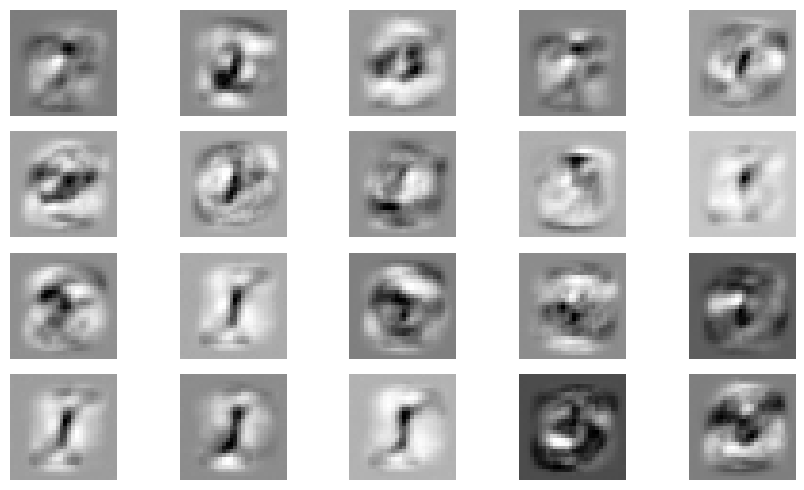

-----Epoch 4 for best model with lr = 0.01 ---------


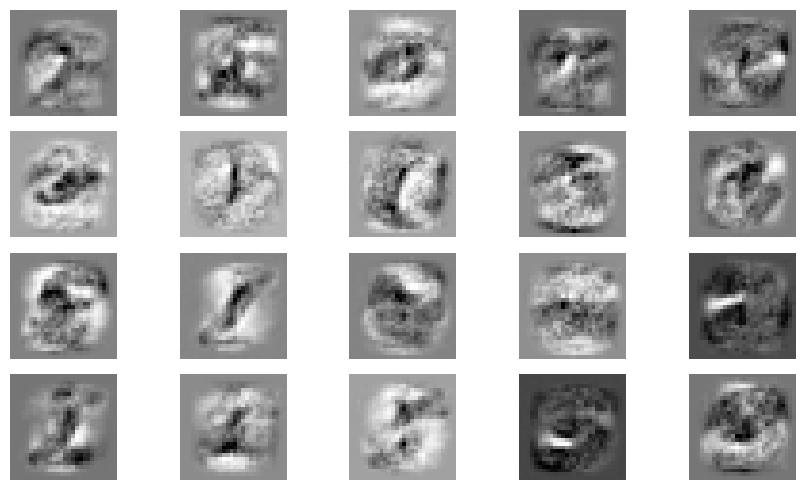

-----Epoch 9 for best model with lr = 0.01 ---------


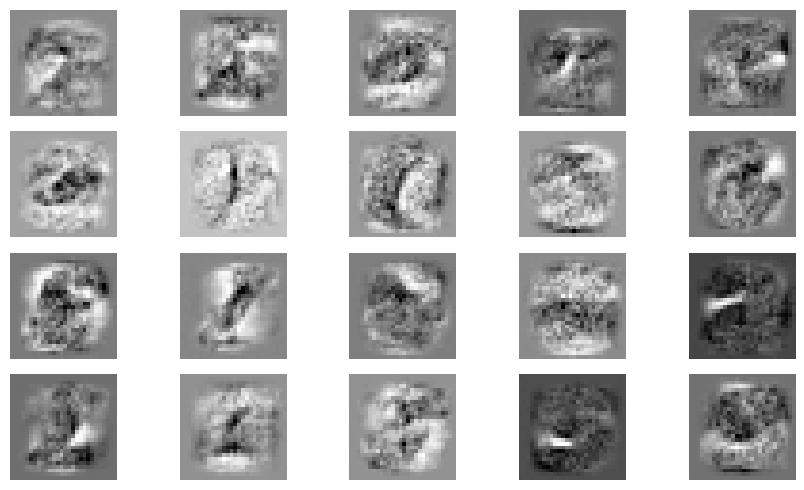

In [20]:
def plot_weights(halves, num_cols, targets=None, shape=(28,28)):
    num_digits = halves[0].shape[1]
    num_rows = int(num_digits/num_cols)


    for w in halves:
        for i in range(num_digits):
            plt.subplot(2, int(num_digits/2), i+1)
            plt.imshow(w[:,i].reshape(shape), interpolation='None', cmap='YlGnBu')
            if targets is not None:
                plt.title("Weight " + str(i),fontsize=11,fontweight="bold")
            plt.colorbar()
            plt.axis('off')
            i +=1
        plt.tight_layout()
        plt.show()

def training_weights(x_train, t_train, x_valid, t_valid, W, b, V, a, lr):
    epochs = []
    log_train = []
    log_val = []
    for epoch in range(10):
      logp_train , W, b, V, a = sgd_mlp_iter(x_train, t_train, W, b, V, a, lr)
      logp_val, _, _ ,_,_= sgd_mlp_iter(x_valid, t_valid, W, b, V, a, lr)
      epochs.append(epoch)
      if epoch in [0,4,9]:
        print("-----Epoch "+str(epoch)+" for best model with lr = 0.01 ---------")
        halves = np.split(V, 2, 1)
        #plot_weights(halves, 5)
        plot_digits(V.T, num_cols=5)




    return W, b, V, a

L=20
K=10
M=28*28
lr=1e-2
W = np.random.normal(size=(L, K), scale=1e-3)
b = np.zeros(K)
V = np.random.normal(size=(M, L), scale=1e-3)
a = np.zeros(L)
W, b, V, a = training_weights(x_train, t_train, x_valid, t_valid, W, b, V, a, lr)


### 2.3.1. Explain the learning curves (5 points)
In less than 80 words, explain the observed behaviour for the different learning rates.

We can observe from these graphs that a learning rate of $1e^{-5}$ results in very small steps and does not converge within the 10 iterations. Bigger learning steps are needed in the beginning, as it is the case for $1e^{-4}$ and $1e^-5$, which ensures that indeed the algorithm does converge

### 2.3.2. Explain the weights (5 points)
In less than 80 words, explain how and why the weights of the hidden layer of the MLP differ from the logistic regression model, and relate this to the stronger performance of the MLP.

The model is able to capture more complex dependencies between the input and the output with the help of the hidden layer.

### 2.3.2. Different activation functions (10 points)
In the task above we use a sigmoid as an activation function.
Two other popular choices for activation functions are tanh and the rectified linear unit (ReLU). The ReLU is defined as:

$$f(x) = \max(0.,x)$$

You already derived the derivative of the softmax function above. Here, write down the derivative for both the tanh and the ReLU function. Furthermore, for all three, plot the function and its derivative in a range $x\in[-3,3]$

Write down the derivative of ReLU and tanh w.r.t. their respective argument:

The ReLU derivative is 0 for x <0, 1 for x > 0, and undefined at 0.


Tanh is given by  $tanh(x) = \frac{e^x  - e^{-x}}{e^x + e ^{-x}}$.

$\frac{\partial \tanh{x}}{\partial x} = 1 - \tanh{(x)}^2$

Name two properties that you would like your activation function to have (one sentence each). Why are they important?

1) Centered around 0. This ensures that the algorithm usually convergences faster. Otherwise, maybe bias on gradient direction, which might slow down learning.

2) Continuously differentiable (almost) everywhere. Necessary for enabling gradient-based optimization methods

3) Non linearity as the purpose of the activation function is to introduce non-linearity into the network.

Nonlinearity: because a main purpose of introducing activation function is to introduce nonlinearity to the system, or else the final result is still equivalent to the single-layer logistic regression.

Approximation: a simple intuition is that when the value before passing activation function is large, the value after should be large as well, and vice versa.


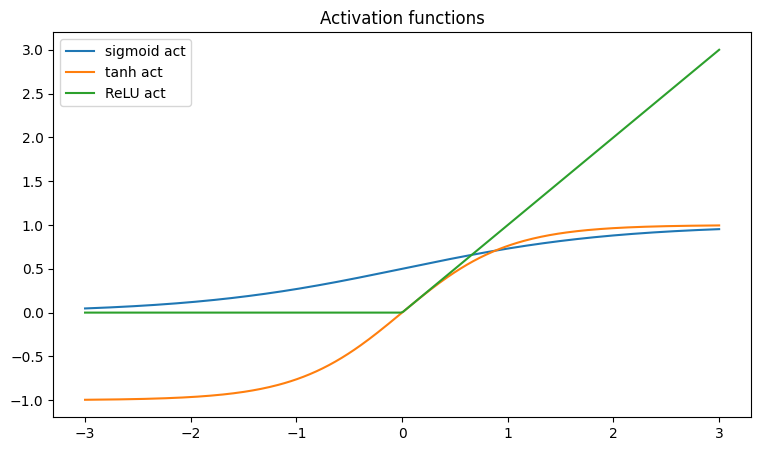

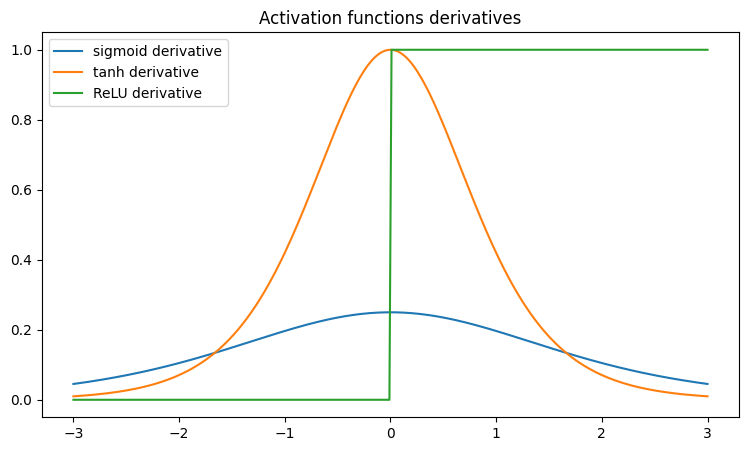

In [21]:
# plot the function and the derivative for the activations sigmoid, tanh and ReLU.

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x)*(1 - sigmoid(x))


from scipy.special import expit

x = np.linspace(start=-3, stop=3, num=300)
plt.plot(x, sigmoid(x), label='sigmoid act')
plt.plot(x, np.tanh(x), label='tanh act')
plt.plot(x, np.maximum(x, 0), label='ReLU act')
plt.title("Activation functions")
plt.legend()
plt.show()

plt.plot(x, sigmoid_derivative(x), label='sigmoid derivative')
plt.plot(x, 1-np.tanh(x)**2, label='tanh derivative')
plt.plot(x, np.where(x>0, 1, 0), label='ReLU derivative')
plt.legend()
plt.title("Activation functions derivatives")
plt.show()


Now that you plotted the activations and derivatives, which activation do you think is the best? Why would you choose this activation function? For your answer consider what you named as essential properties for an activation function above. Keep your answer short at no more then 3 sentences.

Sigmoid is useful for binary classification, however it suffers from vanishing gradient problem, and it is not zero centered. Tanh is zero centered however it still suffers from the vanishing gradient problem. ReLU   and its variants (leakyReLU) have become very popular as they avoid and rectify the vanishing gradient problem. It suffers from problems such as dead neurons, however its variants such as LeakyReLU solve this issue